In [1]:
import util
DATASET_FOLDER = "./data" 
TRAIN_FILES = f"{DATASET_FOLDER}/train_masked.txt"
TEST_FILES =  f"{DATASET_FOLDER}/test_masked.txt"
sampled_ds = util.sample_training_data(TRAIN_FILES, DATASET_FOLDER, samples=15, crop_height=512, crop_width=512)
train_ds, val_ds = util.load_train_val_ds(sampled_ds)


Already generated.


2024-10-30 21:25:24.077599: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-30 21:25:27.442132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30972 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:5e:00.0, compute capability: 7.0


In [2]:
%load_ext autoreload
%autoreload 2

Training set


2024-10-30 21:25:30.460219: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


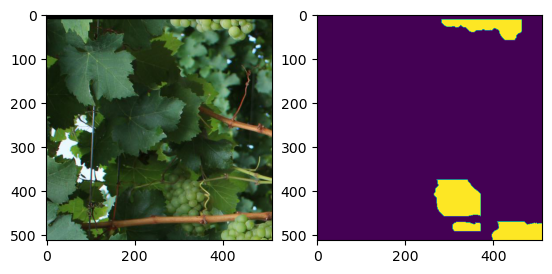

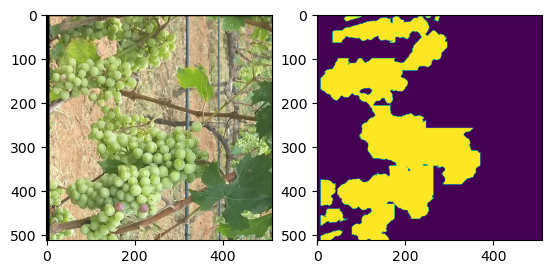

1


In [3]:
import matplotlib.pyplot as plt
print("Training set")
for image, mask in train_ds.take(2):
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(image)
    ax[1].imshow(mask)
    plt.show()
    
print(mask.numpy().max())

Validation set 36


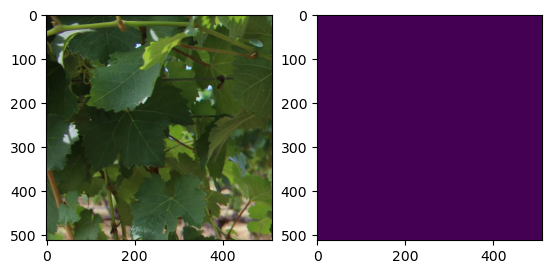

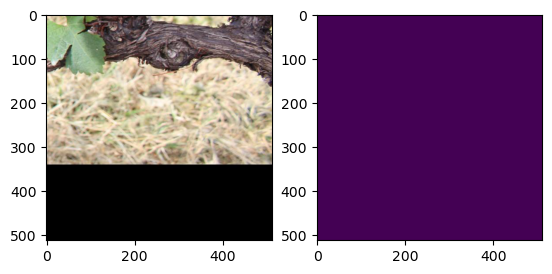

In [6]:
print("Validation set", len(val_ds))
import matplotlib.pyplot as plt
for image, mask in val_ds.take(2):
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(image)
    ax[1].imshow(mask)
    plt.show()
    

In [4]:
import tensorflow as tf
def upsample_block(filters, size, norm_type='batchnorm', apply_dropout=False):
    """Upsamples an input.

  Conv2DTranspose => Batchnorm => Dropout => Relu

  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer

  Returns:
    Upsample Sequential Model
  """
    # initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      # kernel_initializer=initializer,
                                      use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

def downsample_block(filters, size, norm_type='batchnorm', apply_dropout=False):
    """Upsamples an input.

  Conv2DTranspose => Batchnorm => Dropout => Relu

  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer

  Returns:
    Upsample Sequential Model
  """
    # initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2,
                                      padding='same',
                                      # kernel_initializer=initializer,
                                      use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [5]:
import numpy as np
def get_mnet_encoder(input_shape=[None,None,3]):
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
    down_stack.trainable=False
    return down_stack


def get_unet_decoder():
    up_stack = [
        upsample_block(512, 3),  # 4x4 -> 8x8
        upsample_block(256, 3),  # 8x8 -> 16x16
        upsample_block(128, 3),  # 16x16 -> 32x32
        upsample_block(64, 3),   # 32x32 -> 64x64
    ]
    return up_stack 

def conv_block(filters):
    layers = tf.keras.Sequentialuential()
    layers.add(tf.keras.layers.Conv2D(filters, stride=1, padding="same",use_bias=False))
    layers.add(tf.keras.layers.BatchNormalization())
    layers.add(tf.keras.layers.ReLU())
    return layers

def unet_vanilla_model(input_shape=[128,128,3], output_channels=1, config=[32,64,128,256,512]):
    inputs = tf.keras.layers.Input(shape=input_shape)
    first_conv = conv_block(config[0])

def unet_model(input_shape= [None,None,3], output_channels=1):
    inputs = tf.keras.layers.Input(shape=input_shape)
    encoder = get_mnet_encoder(input_shape=input_shape)
    decoder = get_unet_decoder()
    skips = encoder(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(decoder, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.Sequential()  #64x64 -> 128x128
    last.add(tf.keras.layers.Conv2DTranspose(
      filters=16,kernel_size=1,strides=2,
      padding='same'))
    last.add(tf.keras.layers.Conv2D(filters=output_channels, kernel_size=3, padding="same", use_bias=False))
    last.add(tf.keras.layers.BatchNormalization())
    # last.add(tf.keras.layers.Sig
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

def iou_score(truth, prediction, epsilon=1e-6):
    truth = truth.numpy().flatten()
    prediction = prediction.numpy().flatten()
    intersection = np.multiply(truth, prediction).sum()
    union = np.clip(np.add(truth, prediction),0,1).sum() + epsilon
    
    return intersection/union

In [6]:
model = unet_model()
print(model(tf.ones([1,1024,1024,3])).shape)
model.summary()

2024-10-30 21:26:33.277979: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8902
2024-10-30 21:26:34.374407: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-10-30 21:26:34.375328: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-10-30 21:26:34.375342: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2024-10-30 21:26:34.375709: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-10-30 21:26:34.375746: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


(1, 1024, 1024, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, None, None,  1841984     input_1[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, None, 5 1476608     model[0][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, None, None, 1 0           sequential[0][0]                 
                                                                 model[0]

In [7]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]),tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]),tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth))

def combined_bce_dice_loss(gamma=0.2):
    def loss(y_true, y_pred):
        bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
        y_ = tf.cast(tf.nn.sigmoid(y_pred) > 0.5,tf.uint8)
        dice = dice_loss(y_true, y_)
        return (1-gamma)*bce_loss + gamma*dice
    return loss

def dice_score(y_true, y_pred, smooth=1e-6):
    y_pred_f = tf.reshape(tf.cast(tf.nn.sigmoid(y_pred) > 0.5,tf.float32),[-1])
    y_true_f = tf.cast(tf.reshape(y_true, [-1]),tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


In [8]:
a = tf.constant([1.1,2.1,3.1])
b = tf.constant([0,0,1])
loss_fn = combined_bce_dice_loss(gamma=0.2)

loss_fn(b,a), dice_score(b,a)

(<tf.Tensor: shape=(), dtype=float32, numpy=1.0725117>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5000001>)

In [10]:
from pathlib import Path 
import pandas as pd
train_batched = train_ds.batch(8)
val_batched = val_ds.batch(8)
best_model = None
best_val = 9999
loss_fn = combined_bce_dice_loss(gamma=0.2)
learning_rates = [0.01, 0.001, 0.5]
loss_fns = {'0.5': combined_bce_dice_loss(gamma=0.5),'0.2': combined_bce_dice_loss(gamma=0.2), '0':combined_bce_dice_loss(gamma=0)}
patience=5
result_dir = "./results/"
experiment_results = []
for gamma, loss_fn in loss_fns.items():
    for lr in learning_rates:
        prefix = str(lr).replace(".","") +"_"+ str(gamma).replace(".","")
        result_path = Path(result_dir+prefix)
        result_path.mkdir(parents=True, exist_ok=True)
        experiment = {}
        experiment['lr'] = str(lr)
        experiment['gamma'] = gamma 
        experiment['location'] = str(result_path.joinpath("best.hd5"))
        print(experiment)
        model = unet_model(input_shape=[None,None,3])
        model.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Adam(learning_rate=lr),metrics=[dice_score])
        early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience, monitor="val_loss", restore_best_weights=True)
        history = model.fit(train_batched, validation_data=val_batched, epochs=60,callbacks=[early_stopping],verbose=1)
        experiment['training_loss'] = history.history['loss']
        experiment['validating_loss'] = history.history['val_loss']
        experiment['val_dice_score'] = history.history['val_dice_score']
        experiment['final_val_dice_score'] = experiment['val_dice_score'][(patience+1)*-1]
        print("Validation dice score",experiment['val_dice_score'][(patience+1)*-1])
        experiment_results.append(experiment)
        tf.keras.models.save_model(model,result_path.joinpath("best.hd5"))
        del model
pd.DataFrame(experiment_results).to_csv(result_dir+"result.csv",index=False)


{'lr': '0.01', 'gamma': '0.5', 'location': 'results/001_05/best.hd5'}
Epoch 1/60
18/18 [==============================] - 4s 136ms/step - loss: 0.5523 - dice_score: 0.4882 - val_loss: 177.3067 - val_dice_score: 0.1833
Epoch 2/60
18/18 [==============================] - 2s 95ms/step - loss: 0.3531 - dice_score: 0.7526 - val_loss: 19.9226 - val_dice_score: 0.1833
Epoch 3/60
18/18 [==============================] - 2s 94ms/step - loss: 0.3175 - dice_score: 0.7591 - val_loss: 8.7390 - val_dice_score: 0.1833
Epoch 4/60
18/18 [==============================] - 2s 94ms/step - loss: 0.2559 - dice_score: 0.8251 - val_loss: 2.5004 - val_dice_score: 0.1919
Epoch 5/60
18/18 [==============================] - 2s 95ms/step - loss: 0.2607 - dice_score: 0.7857 - val_loss: 1.4224 - val_dice_score: 0.2076
Epoch 6/60
18/18 [==============================] - 2s 94ms/step - loss: 0.2263 - dice_score: 0.8156 - val_loss: 1.0291 - val_dice_score: 0.3112
Epoch 7/60
18/18 [==============================] - 2s 9

2024-10-30 21:28:07.457412: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: results/001_05/best.hd5/assets


/common/cse479/shared/envs/tensorflow-env/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


{'lr': '0.001', 'gamma': '0.5', 'location': 'results/0001_05/best.hd5'}
Epoch 1/60
18/18 [==============================] - 4s 133ms/step - loss: 0.6504 - dice_score: 0.3529 - val_loss: 0.5319 - val_dice_score: 0.4706
Epoch 2/60
18/18 [==============================] - 2s 95ms/step - loss: 0.4713 - dice_score: 0.6067 - val_loss: 0.4207 - val_dice_score: 0.6308
Epoch 3/60
18/18 [==============================] - 2s 96ms/step - loss: 0.4270 - dice_score: 0.6773 - val_loss: 0.4534 - val_dice_score: 0.6035
Epoch 4/60
18/18 [==============================] - 2s 94ms/step - loss: 0.4095 - dice_score: 0.7022 - val_loss: 0.5919 - val_dice_score: 0.4588
Epoch 5/60
18/18 [==============================] - 2s 95ms/step - loss: 0.3995 - dice_score: 0.7139 - val_loss: 0.3154 - val_dice_score: 0.7944
Epoch 6/60
18/18 [==============================] - 2s 94ms/step - loss: 0.4004 - dice_score: 0.7056 - val_loss: 0.3957 - val_dice_score: 0.6913
Epoch 7/60
18/18 [==============================] - 2s 94

/common/cse479/shared/envs/tensorflow-env/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


{'lr': '0.5', 'gamma': '0.5', 'location': 'results/05_05/best.hd5'}
Epoch 1/60
18/18 [==============================] - 4s 135ms/step - loss: 0.6791 - dice_score: 0.0221 - val_loss: 0.7332 - val_dice_score: 0.1211
Epoch 2/60
18/18 [==============================] - 2s 95ms/step - loss: 0.6643 - dice_score: 6.5929e-12 - val_loss: 0.6569 - val_dice_score: 7.2187e-12
Epoch 3/60
18/18 [==============================] - 2s 95ms/step - loss: 0.6564 - dice_score: 5.9313e-12 - val_loss: 0.6562 - val_dice_score: 7.2187e-12
Epoch 4/60
18/18 [==============================] - 2s 94ms/step - loss: 0.6539 - dice_score: 6.9613e-12 - val_loss: 0.6560 - val_dice_score: 7.2187e-12
Epoch 5/60
18/18 [==============================] - 2s 95ms/step - loss: 0.6549 - dice_score: 6.4046e-12 - val_loss: 0.6560 - val_dice_score: 7.2187e-12
Epoch 6/60
18/18 [==============================] - 2s 94ms/step - loss: 0.6545 - dice_score: 8.9793e-12 - val_loss: 0.6571 - val_dice_score: 7.2187e-12
Epoch 7/60
18/18 [===

/common/cse479/shared/envs/tensorflow-env/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


{'lr': '0.01', 'gamma': '0.2', 'location': 'results/001_02/best.hd5'}
Epoch 1/60
18/18 [==============================] - 5s 136ms/step - loss: 0.5738 - dice_score: 0.4970 - val_loss: 134.0500 - val_dice_score: 0.1833
Epoch 2/60
18/18 [==============================] - 2s 95ms/step - loss: 0.4263 - dice_score: 0.7165 - val_loss: 16.6121 - val_dice_score: 0.1833
Epoch 3/60
18/18 [==============================] - 2s 94ms/step - loss: 0.3625 - dice_score: 0.7657 - val_loss: 6.3095 - val_dice_score: 0.1855
Epoch 4/60
18/18 [==============================] - 2s 95ms/step - loss: 0.3110 - dice_score: 0.8103 - val_loss: 4.2022 - val_dice_score: 0.1877
Epoch 5/60
18/18 [==============================] - 2s 94ms/step - loss: 0.2743 - dice_score: 0.8270 - val_loss: 2.3911 - val_dice_score: 0.2073
Epoch 6/60
18/18 [==============================] - 2s 97ms/step - loss: 0.2571 - dice_score: 0.8032 - val_loss: 1.6830 - val_dice_score: 0.2084
Epoch 7/60
18/18 [==============================] - 2s 9

/common/cse479/shared/envs/tensorflow-env/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


{'lr': '0.001', 'gamma': '0.2', 'location': 'results/0001_02/best.hd5'}
Epoch 1/60
18/18 [==============================] - 4s 133ms/step - loss: 0.6305 - dice_score: 0.3786 - val_loss: 1.2355 - val_dice_score: 0.1966
Epoch 2/60
18/18 [==============================] - 2s 94ms/step - loss: 0.5231 - dice_score: 0.5847 - val_loss: 1.0131 - val_dice_score: 0.2374
Epoch 3/60
18/18 [==============================] - 2s 94ms/step - loss: 0.4949 - dice_score: 0.6627 - val_loss: 0.7640 - val_dice_score: 0.3589
Epoch 4/60
18/18 [==============================] - 2s 94ms/step - loss: 0.4836 - dice_score: 0.6801 - val_loss: 0.7779 - val_dice_score: 0.2950
Epoch 5/60
18/18 [==============================] - 2s 95ms/step - loss: 0.4650 - dice_score: 0.7224 - val_loss: 0.6862 - val_dice_score: 0.3935
Epoch 6/60
18/18 [==============================] - 2s 94ms/step - loss: 0.4570 - dice_score: 0.7287 - val_loss: 0.4728 - val_dice_score: 0.7248
Epoch 7/60
18/18 [==============================] - 2s 94

/common/cse479/shared/envs/tensorflow-env/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


{'lr': '0.5', 'gamma': '0.2', 'location': 'results/05_02/best.hd5'}
Epoch 1/60
18/18 [==============================] - 4s 134ms/step - loss: 0.5040 - dice_score: 0.0239 - val_loss: 0.7494 - val_dice_score: 7.2187e-12
Epoch 2/60
18/18 [==============================] - 2s 94ms/step - loss: 0.4610 - dice_score: 7.2944e-12 - val_loss: 12.3844 - val_dice_score: 0.1871
Epoch 3/60
18/18 [==============================] - 2s 94ms/step - loss: 0.2292 - dice_score: 0.5471 - val_loss: 27.5682 - val_dice_score: 0.1869
Epoch 4/60
18/18 [==============================] - 2s 94ms/step - loss: 0.1575 - dice_score: 0.7195 - val_loss: 14.6096 - val_dice_score: 0.1877
Epoch 5/60
18/18 [==============================] - 2s 94ms/step - loss: 0.1566 - dice_score: 0.7389 - val_loss: 14.9285 - val_dice_score: 0.1838
Epoch 6/60
18/18 [==============================] - 2s 94ms/step - loss: 0.1364 - dice_score: 0.7567 - val_loss: 4.0173 - val_dice_score: 0.2118
Validation dice score 7.218724316221392e-12
INFO:

/common/cse479/shared/envs/tensorflow-env/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


{'lr': '0.01', 'gamma': '0', 'location': 'results/001_0/best.hd5'}
Epoch 1/60
18/18 [==============================] - 4s 134ms/step - loss: 0.5766 - dice_score: 0.5401 - val_loss: 353.6912 - val_dice_score: 0.1833
Epoch 2/60
18/18 [==============================] - 2s 95ms/step - loss: 0.4548 - dice_score: 0.7640 - val_loss: 56.0844 - val_dice_score: 0.1833
Epoch 3/60
18/18 [==============================] - 2s 94ms/step - loss: 0.4009 - dice_score: 0.7520 - val_loss: 22.1209 - val_dice_score: 0.1833
Epoch 4/60
18/18 [==============================] - 2s 94ms/step - loss: 0.3382 - dice_score: 0.8144 - val_loss: 8.7280 - val_dice_score: 0.1836
Epoch 5/60
18/18 [==============================] - 2s 94ms/step - loss: 0.3081 - dice_score: 0.7876 - val_loss: 3.1044 - val_dice_score: 0.1895
Epoch 6/60
18/18 [==============================] - 2s 94ms/step - loss: 0.2729 - dice_score: 0.8073 - val_loss: 1.5305 - val_dice_score: 0.2520
Epoch 7/60
18/18 [==============================] - 2s 94m

/common/cse479/shared/envs/tensorflow-env/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


{'lr': '0.001', 'gamma': '0', 'location': 'results/0001_0/best.hd5'}
Epoch 1/60
18/18 [==============================] - 4s 133ms/step - loss: 0.6448 - dice_score: 0.3705 - val_loss: 0.8996 - val_dice_score: 0.2879
Epoch 2/60
18/18 [==============================] - 2s 94ms/step - loss: 0.5492 - dice_score: 0.6114 - val_loss: 1.0153 - val_dice_score: 0.2953
Epoch 3/60
18/18 [==============================] - 2s 94ms/step - loss: 0.5296 - dice_score: 0.7082 - val_loss: 1.1458 - val_dice_score: 0.2607
Epoch 4/60
18/18 [==============================] - 2s 94ms/step - loss: 0.5228 - dice_score: 0.6989 - val_loss: 0.7610 - val_dice_score: 0.3479
Epoch 5/60
18/18 [==============================] - 2s 94ms/step - loss: 0.5190 - dice_score: 0.6854 - val_loss: 0.6620 - val_dice_score: 0.4144
Epoch 6/60
18/18 [==============================] - 2s 94ms/step - loss: 0.5038 - dice_score: 0.7400 - val_loss: 0.6954 - val_dice_score: 0.3664
Epoch 7/60
18/18 [==============================] - 2s 94ms/

/common/cse479/shared/envs/tensorflow-env/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


{'lr': '0.5', 'gamma': '0', 'location': 'results/05_0/best.hd5'}
Epoch 1/60
18/18 [==============================] - 4s 133ms/step - loss: 0.4119 - dice_score: 0.0132 - val_loss: 0.3498 - val_dice_score: 7.2187e-12
Epoch 2/60
18/18 [==============================] - 2s 94ms/step - loss: 0.3234 - dice_score: 6.4367e-12 - val_loss: 0.3154 - val_dice_score: 7.2187e-12
Epoch 3/60
18/18 [==============================] - 2s 95ms/step - loss: 0.3082 - dice_score: 6.1953e-12 - val_loss: 0.3139 - val_dice_score: 7.2187e-12
Epoch 4/60
18/18 [==============================] - 2s 95ms/step - loss: 0.3090 - dice_score: 7.2478e-12 - val_loss: 0.3120 - val_dice_score: 7.2187e-12
Epoch 5/60
18/18 [==============================] - 2s 93ms/step - loss: 0.3073 - dice_score: 6.8384e-12 - val_loss: 0.3129 - val_dice_score: 7.2187e-12
Epoch 6/60
18/18 [==============================] - 2s 94ms/step - loss: 0.3097 - dice_score: 6.8396e-12 - val_loss: 0.3159 - val_dice_score: 7.2187e-12
Epoch 7/60
18/18 [==

/common/cse479/shared/envs/tensorflow-env/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


1.0


TypeError: 'NoneType' object is not callable

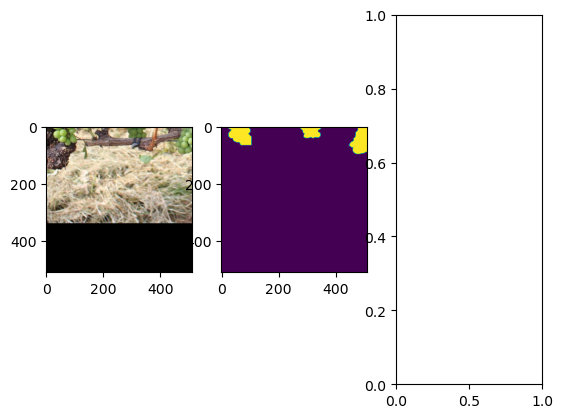

In [11]:
import matplotlib.pyplot as plt
for image, mask in val_ds.take(6):
    fig,ax = plt.subplots(1,3)
    ax[0].imshow(image)
    ax[1].imshow(mask)
    print(mask.numpy().max())
    prediction = tf.nn.sigmoid(best_model(image[None]))
    prediction = prediction[0]>0.5
    prediction = tf.cast(prediction, tf.float32)
    ax[2].imshow(prediction)

    plt.show()

(512, 512, 1) (512, 512, 1)


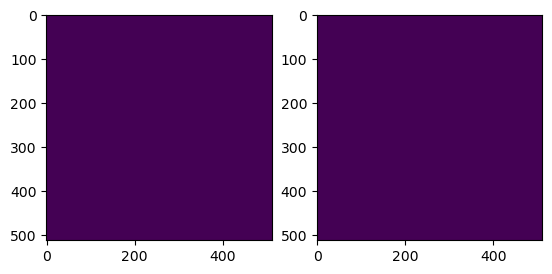

In [46]:

predictions = tf.nn.sigmoid(best_model.predict(val_batched)) > 0.5
truth = tf.concat([mask for _,mask in val_batched],axis=0)
for prediction, trith in zip(predictions,truth):
    print(prediction.shape,trith.shape)
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(prediction)
    ax[1].imshow(trith)

    plt.show()
    break
    


In [50]:
iou_score(truth, predictions), dice_score(truth, best_model.predict(val_batched))

(0.7910890295690675, <tf.Tensor: shape=(), dtype=float32, numpy=0.8833609>)

In [118]:
tf.keras.models.save_model(best_model, "best_model_custom_loss.hd5")

INFO:tensorflow:Assets written to: best_model.hd5/assets


/common/cse479/shared/envs/tensorflow-env/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [51]:
import util
def resize(i,m):
    i = tf.image.resize_with_pad(i, 1024,1024)
    m = tf.image.resize_with_pad(m, 1024,1024)
    return i,m

def normalize_for_test(image,mask):
    image = tf.cast(image,tf.float32)/255.0
    # mask_max = tf.reduce_max(mask)
    return image,mask



test_ds = util.get_test_ds("./data/test_masked.txt","./data").map(resize).map(normalize_for_test)

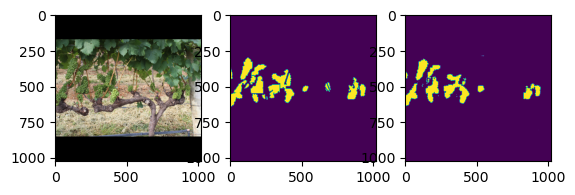

(1024, 1024, 3) (1024, 1024, 1)


In [52]:

for i,m in test_ds.take(1):
    fig,ax = plt.subplots(1,3)
    ax[0].imshow(i.numpy())
    ax[1].imshow(m.numpy())
    prediction = best_model(i[None])
    prediction = tf.nn.sigmoid(prediction[0].numpy())>0.5
    ax[2].imshow(prediction)
    plt.show()
    print(i.shape,m.shape)

In [53]:
iou_score(m,prediction)

0.7201862575637571

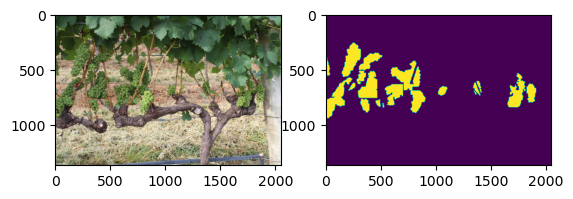

(1365, 2048, 3) (1365, 2048, 1)


In [54]:
import util
test_ds = util.get_test_ds("./data/test_masked.txt","./data").map(normalize_for_test)

for i,m in test_ds.take(1):
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(i.numpy())
    ax[1].imshow(m.numpy())
    images,masks = util.generate_crops_with_padding(i,m)
    predictions = best_model(images)
    predictions = tf.nn.sigmoid(predictions)>0.5
    # ax[2].imshow(prediction)
    plt.show()
    print(i.shape,m.shape)

In [55]:
iou_score(predictions,masks)

0.8289009956481429

In [190]:
images.shape

TensorShape([12, 512, 512, 3])